In [1]:
import pandas as pd
import numpy as np
import random
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

train_dir = './data/cropped'




In [2]:
import os
import pandas as pd

# create a dictionary to store the number of files in each subdirectory
num_files = {}
for subdir in os.listdir(train_dir):
    path = os.path.join(train_dir, subdir)
    if os.path.isdir(path):
        num_files[subdir] = len(os.listdir(path))

# create a pandas dataframe to display the results in a table
df = pd.DataFrame.from_dict(num_files, orient='index', columns=['Number of Files'])
df.index.name = 'Subdirectory'
display(df)


,Number of Files
Subdirectory,
NonDrowsy,158
Drowsy,197


Randomly pick 100 images from each directory

In [3]:
def data_preprocess_step1(train_dir, num_images=100):
    # create empty lists to store the images and their labels
    images = []
    labels = []

    # loop through each subdirectory
    for subdir in os.listdir(train_dir):
        path = os.path.join(train_dir, subdir)
        print(path)
        if os.path.isdir(path):
            # get a list of all the image files in the subdirectory
            image_files = os.listdir(path)
            # randomly select num_images images from the list
            selected_images = random.sample(image_files, num_images)
            # loop through the selected images
            for image_file in selected_images:
                # load the image using load_img
                
                img = load_img(os.path.join(path, image_file), target_size=(80, 80))
                # convert the image to an array using img_to_array
                img_array = img_to_array(img)
                # append the image and its label to the lists
                images.append(img_array)
                if subdir == "Drowsy":
                    labels.append(1)
                else:
                    labels.append(0)

    # convert the images and labels to numpy arrays
    images = np.stack(images)
    labels = np.array(labels).flatten()
    return images, labels


In [4]:
# generate images and labels based on preprocess_data_part1() function
images, y = data_preprocess_step1(train_dir)

print(f"images_mini shape {images.shape}")
print(f"y_mini shape {y.shape}")

./data/cropped/NonDrowsy
./data/cropped/Drowsy
images_mini shape (200, 80, 80, 3)
y_mini shape (200,)


2023-11-25 13:59:56.932578: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-25 13:59:56.932603: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-25 13:59:56.932611: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-25 13:59:56.932649: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-25 13:59:56.932668: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


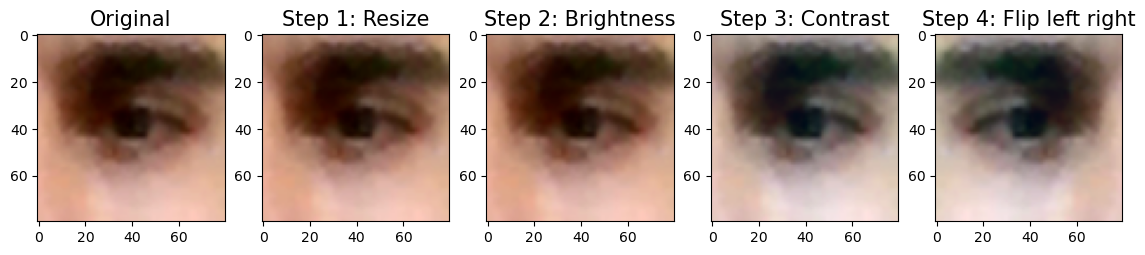

In [5]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images[0]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(image, size=(80, 80))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);


# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

In [6]:
IMAGE_SIZE = (80, 80)
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data_step2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1235)
    np.random.seed(1235)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])
    
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)
    
    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_step2(
    images,
    y,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (240, 80, 80, 3)
y_train shape (240,)
X_val shape (40, 80, 80, 3)
y_val shape (40,)
X_test shape (40, 80, 80, 3)
y_test shape (40,)


Print training data examples:


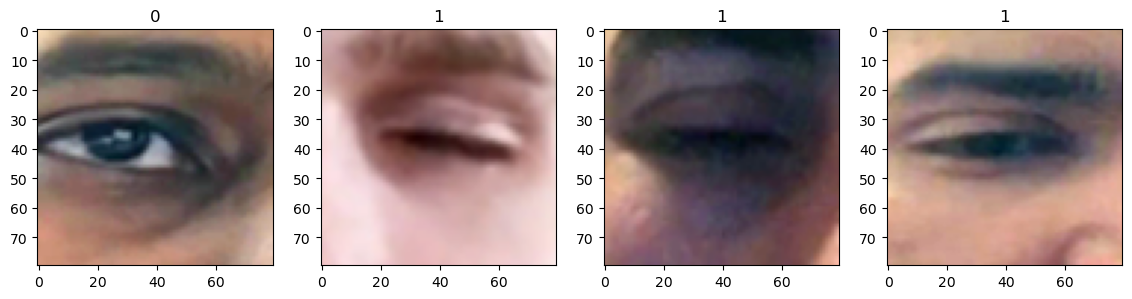

In [8]:
# print taining data
print('Print training data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_train[i]))
    axs[i].set(title=y_train[i])

Print validation data examples:


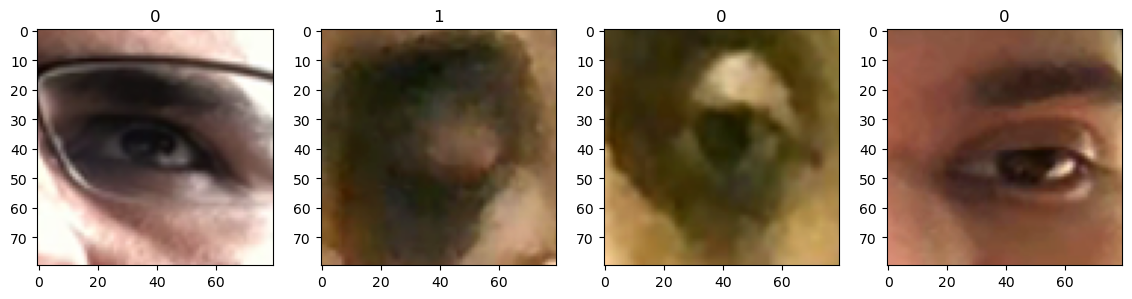

In [9]:
# print test data
print('Print validation data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_val[i]))
    axs[i].set(title=y_val[i])

In [ ]:
def build_modelV1():
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential()
    
    # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        data_format='channels_last',
        name='conv_1',
        activation='relu'))
    
    
    # add a max pooling layer with pool size (2,2) and strides of 2
    # (this will reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2, 2),
        name='pool_1'))
    
    
    # add second convolutional layer
    model.add(tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        name='conv_2',
        activation='relu'))
    
    
    # add second max pooling layer with pool size (2,2) and strides of 2
    # (this will further reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2, 2), name='pool_2')
    )
    
    
    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
        units=1024,
        name='fc_1', 
        activation='relu'))
    
    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    
    # add the last fully connected layer
    # this last layer sets the activation function to "None" in order to output the logits 
    # note that passing activation = "sigmoid" will return class memembership probabilities but
    # in TensorFlow logits are prefered for numerical stability
    # set units=1 to get a single output unit (remember it's a binary classification problem)
    model.add(tf.keras.layers.Dense(
        units=1,
        name='fc_2',
        activation=None))
    
    # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 80, 80, 3))
    
    
    return model

In [10]:
def build_modelV2():
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential()
    
    # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        data_format='channels_last',
        name='conv_1',
        activation='relu'))
    
    
    # add a max pooling layer with pool size (2,2) and strides of 2
    # (this will reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2, 2),
        name='pool_1'))
    
    
    # add second convolutional layer
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        name='conv_2',
        activation='relu'))
    
    
    # add second max pooling layer with pool size (2,2) and strides of 2
    # (this will further reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2, 2), name='pool_2')
    )
    
    
    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
        units=256,
        name='fc_1', 
        activation='relu'))
    
    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))
    
    model.add(tf.keras.layers.Dense(
        units=128,
        name='fc_2', 
        activation='relu'))
    
    model.add(tf.keras.layers.Dense(
        units=64,
        name='fc_3', 
        activation='relu'))
    
    # add the last fully connected layer
    # this last layer sets the activation function to "None" in order to output the logits 
    # note that passing activation = "sigmoid" will return class memembership probabilities but
    # in TensorFlow logits are prefered for numerical stability
    # set units=1 to get a single output unit (remember it's a binary classification problem)
    model.add(tf.keras.layers.Dense(
        units=1,
        name='fc_4',
        activation=None))
    
    # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 80, 80, 3))
    
    
    return model

In [ ]:
def build_modelV3():

    # Instantiate the model
    model = tf.keras.Sequential()

    # Adding first three convolutional layers
    model.add(tf.keras.layers.Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu', # activation function 
                    input_shape = (80,80,3) # shape of input (image)
                    ))
    model.add(tf.keras.layers.Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu' # activation function 
                    ))
    model.add(tf.keras.layers.Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu' # activation function 
                    ))

    # Adding pooling after convolutional layers
    model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2))) # Dimensions of the region that you are pooling

    # Adding second set of convolutional layers
    model.add(tf.keras.layers.Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu' # activation function 
                    ))
    model.add(tf.keras.layers.Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu' # activation function 
                    ))

    # Add last pooling layer.
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Flatten())

    # Adding first dense layer with 256 nodes
    model.add(tf.keras.layers.Dense(256, activation='relu'))

    # Adding a dropout layer to avoid overfitting
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3)) 

    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))

    # adding output layer
    model.add(tf.keras.layers.Dense(1, activation = None))

        # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 80, 80, 3))

    return model

In [19]:

model = build_modelV2()
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy']) 



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 80, 80, 32)        2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 40, 40, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 40, 40, 32)        25632     
                                                                 
 pool_2 (MaxPooling2D)       (None, 20, 20, 32)        0         
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 fc_1 (Dense)                (None, 256)               3277056   
                                                                 
 dropout (Dropout)           (None, 256)               0

In [23]:
tf.random.set_seed(1235)
np.random.seed(1235)

image_test, label_test = data_preprocess_step1('./data/test_cropped/', num_images=50)

shuffle = np.random.permutation(np.arange(image_test.shape[0]))
image_test, label_test = image_test[shuffle], label_test[shuffle]

test_results = model.evaluate(image_test, label_test)
print('\nBaseline Test Acc. {:.2f}%'.format(test_results[1]*100))

./data/test_cropped/NonDrowsy
./data/test_cropped/Drowsy
4/4 [==============================] - 0s 27ms/step - loss: 45.9817 - accuracy: 0.8500

Baseline Test Acc. 85.00%


2023-11-25 14:03:49.934482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [24]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(1234)
np.random.seed(1234)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=30, 
                    validation_data=(X_val, y_val)
                    callbacks=[early_stopping]
)


Epoch 1/30


2023-11-25 14:03:53.614794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 67ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.6560 - val_accuracy: 0.8000
Epoch 2/30
1/8 [==>...........................] - ETA: 0s - loss: 0.0081 - accuracy: 1.0000

2023-11-25 14:03:54.227357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 36ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.6471 - val_accuracy: 0.8000
Epoch 3/30
8/8 [==============================] - 0s 31ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.6917 - val_accuracy: 0.8250
Epoch 4/30
8/8 [==============================] - 0s 30ms/step - loss: 0.0227 - accuracy: 0.9958 - val_loss: 0.6360 - val_accuracy: 0.7750
Epoch 5/30
8/8 [==============================] - 0s 29ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.6893 - val_accuracy: 0.8250
Epoch 6/30
8/8 [==============================] - 0s 29ms/step - loss: 0.0250 - accuracy: 0.9917 - val_loss: 0.6052 - val_accuracy: 0.8000
Epoch 7/30
8/8 [==============================] - 0s 29ms/step - loss: 0.0185 - accuracy: 0.9958 - val_loss: 0.5527 - val_accuracy: 0.8000
Epoch 8/30
8/8 [==============================] - 0s 29ms/step - loss: 0.0343 - accuracy: 0.9750 - val_loss: 0.7138 - val_accuracy: 0.8250
Epoch 9/30
8/8 [======================

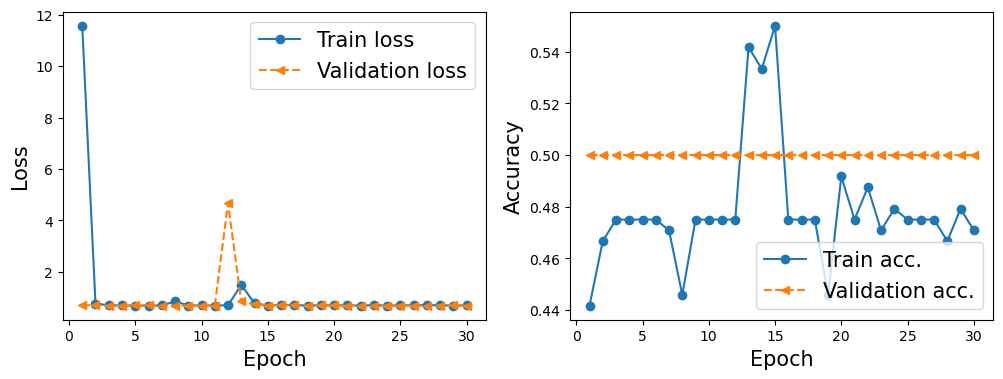

In [18]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [ ]:
test_results = model.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

In [ ]:
img_tensor = np.expand_dims(X_train[2], axis = 0)

# Print image tensor shape
print('Shape of image:', img_tensor.shape)
  
# Print image
plt.imshow(img_tensor[0])
plt.title('label:' + str(y_train[1]))
plt.show()

In [ ]:
# outputs of the first 4 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:4]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)

# grab layer names
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)

# getting activations of each layer
for idx, layer in enumerate(activations):
    if idx in (0,1,2,3):
        print('----------------')
        print('Geeting activations of layer',  idx+1, ':', layer_names[idx])
        activation = layer

        # shape of layer activation
        print('Images size is', activation.shape[1], 'x', activation.shape[2])
        print('Number of channels is', activation.shape[3])

        # print channels
        print('Printing channels:')
        
        # define nrows and ncols depending on number of channels
        if idx in (0,1):
            nrows, ncols = 4,8
        if idx in (2,3):
            nrows, ncols = 8,8

        # plots
        channel=0
        if idx in (0,1):
            f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
        if idx in (2,3):
            f, axs = plt.subplots(nrows, ncols, figsize=(16,20))
            
        for i in range(nrows):
            for j in range(ncols):
                if i==0 and j==0:
                    channel=0
                else:
                    channel+=1

                im = axs[i,j].matshow(activation[0,:, :, channel], cmap ='viridis')
                axs[i,j].set(title=str(channel))
                plt.colorbar(im, ax=axs[i, j], fraction=0.046, pad=0.04)
                #axs[i,j].axis('off') # pay attention to the range of x and y axis
        
        plt.show()
        

In [ ]:
tf.random.set_seed(1235)
np.random.seed(1235)

image_test, label_test = data_preprocess_step1('./data/test_cropped/', num_images=50)

shuffle = np.random.permutation(np.arange(image_test.shape[0]))
image_test, label_test = image_test[shuffle], label_test[shuffle]

test_results = model.evaluate(image_test, label_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

#print(label_test)


In [ ]:
pred_logits = model.predict(image_test)
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 50))

for j, example in enumerate(image_test):
    ax = fig.add_subplot(int(len(label_test)/4),4, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(array_to_img(example))
    if label_test[j]==0:
        label='Non Drowsy'
    else:
        label='Drowsy'
    
    ax.text(
        0.5, -0.15, 
        'GT: {:s}\nPr(Drowsy)={:.0f}%'.format(label, probas[j]), 
        size=10, 
        color='black',
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
plt.tight_layout()
plt.show()



In [ ]:
from tensorflow import keras
import pandas as pd
from IPython.display import display, Image


def predict(model, img):
    img= keras.utils.load_img(
        img, target_size=(80, 80))
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)

    return predictions


dir_path = "./data/test_cropped/Drowsy/"
i = 0
file_path = []
prediction_results = []
for file_name in os.listdir(dir_path):
    
    predictions = predict(model, dir_path+file_name)
    
    print (predictions)
    
    # Convert logits to probabilities
    probabilities = tf.nn.sigmoid(predictions).numpy()
    
    prediction_results.append(probabilities[0])
    file_path.append(dir_path+file_name)



data = {'file_path': file_path, 'prediction_results': prediction_results}
df = pd.DataFrame(data)


'''
# Display the dataframe with filepath as a link to the image
for index, row in df.iterrows():
    display(Image(filename=row['file_path']))
    print(row)
'''

    

# Define the grid size based on the number of images
num_images = len(df)
grid_size = int(num_images ** 0.5) + 1

# Create a grid of subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(12, 12))

# Iterate over the dataframe rows and display the image with prediction result
for index, row in df.iterrows():
    img = plt.imread(row['file_path'])
    ax = axs[index // grid_size, index % grid_size]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Prediction: {row['prediction_results']:.2f}")

# Remove empty subplots
for i in range(num_images, grid_size ** 2):
    axs[i // grid_size, i % grid_size].axis('off')

plt.tight_layout()
plt.show()




print(np.array(prediction_results))
array = np.array(prediction_results)
print(np.size(array))

um_elements_greater_than_zero = np.sum(array > 0)

print (um_elements_greater_than_zero)

um_elements_less_than_zero = np.sum(array < 0)
print (um_elements_less_than_zero)
